In [ ]:
%pip install -q matplotlib 
%pip install -q seaborn
%pip install -q pandas
%pip install -q numpy

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os 

In [3]:
ior_results_dirs = [
    'ior_results_n-1_seg-1_20250904',
    'ior_results_n-1_seg-6_20250904',
    'ior_results_n-2_seg-1_20250904'
]

# for each csv in each dir
# take the highest bandwidth row
df = pd.DataFrame()
for dir in ior_results_dirs:
    for file_name in os.listdir(dir):
        if file_name.endswith('.csv'): 
            file = os.path.join(dir, file_name)
            tmp = pd.read_csv(file)
            tmp = (tmp.iloc[tmp.idxmax(numeric_only=True)['bw(MiB/s)']].to_frame().T)
            tmp['fromCSV'] = file_name
            df = pd.concat([df,tmp], ignore_index=True)

df.to_csv('ior_results.csv')
print(df.to_string())

   access    bw(MiB/s)         IOPS Latency block(KiB) xfer(KiB) open(s) wr/rd(s) close(s) total(s) numTasks iter                       fromCSV
0   write   54131.8748    3801.8429  0.0027   131072.0   16384.0  0.0061   0.0253   0.0062   0.0284       12    3   write_n-1_ppn-12_tx-16M.csv
1   write    1316.8775    84393.243  0.0003   131072.0      16.0  0.0163   2.3297   0.1345   2.3328       24    1   write_n-1_ppn-24_tx-16K.csv
2   write   14840.0401   14893.0812  0.0047   131072.0    1024.0  0.0502   0.8251   0.2748    0.828       96    3    write_n-1_ppn-96_tx-1M.csv
3   write   37273.9661    2400.2383   0.005   131072.0   16384.0  0.0219   0.1067   0.0691   0.1099       32    3   write_n-1_ppn-32_tx-16M.csv
4   write   20118.0736   20318.6062  0.0018   131072.0    1024.0  0.0243   0.3024   0.0761   0.3054       48    3    write_n-1_ppn-48_tx-1M.csv
5   write   29790.5786   15244.7873  0.0012   131072.0    2048.0  0.0174   0.1343    0.071   0.1375       32    3    write_n-1_ppn-32_tx

   access   bw(MiB/s)        IOPS Latency block(KiB) xfer(KiB) open(s)  \
6   write   32190.124  16633.1057   0.001   131072.0    2048.0  0.0151   
17  write  17390.1274  17701.6671  0.0009   131072.0    1024.0  0.0131   
38  write  36504.6545  18368.3068   0.005   131072.0    2048.0  0.0125   
79  write  35266.2213  36545.2412  0.0004   131072.0    1024.0  0.0059   

   wr/rd(s) close(s) total(s) numTasks iter                     fromCSV  
6    0.0923   0.0312   0.0954       24    4  write_n-1_ppn-24_tx-2M.csv  
17   0.1735   0.0579   0.1767       24    4  write_n-1_ppn-24_tx-1M.csv  
38   0.5017   0.1851   0.5049       24    4  write_n-1_ppn-24_tx-2M.csv  
79   0.0841   0.0287   0.0871       24    4  write_n-2_ppn-12_tx-1M.csv  


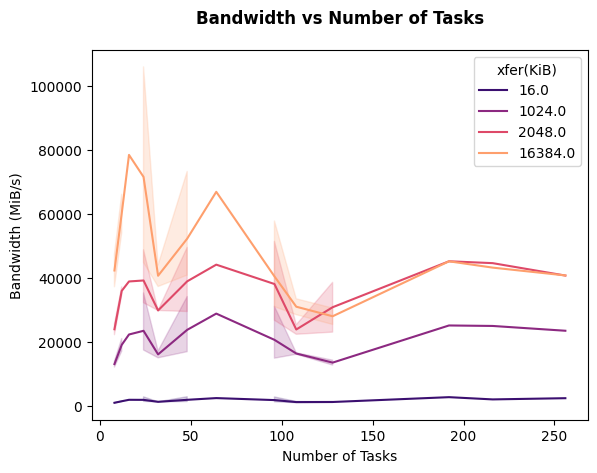

In [12]:
palette = sns.color_palette("magma", len(df["xfer(KiB)"].unique())) 
ax = sns.lineplot(
                data=df,
                x="numTasks",
                y="bw(MiB/s)",
                hue="xfer(KiB)",
                # style="rand_seq_type", dashes=dashes,
                # marker='o',
                # hue_order=hue_order,
                # order=bs_order,
                palette=palette
            )
# ax.set_xticks(subdf["job options.numjobs"].unique())
ax.set_xlabel("Number of Tasks")
ax.set_ylabel("Bandwidth (MiB/s)")
ax.set_title("Bandwidth vs Number of Tasks", weight="bold", x=0.5, y=1.05)
print(df[((df['numTasks']==24) & (df['iter']==4))])